This file contains an enhanced version of the Sharing_resources.ipynb file:
* the code has been slighlty refactored (e.g. more explicit variable names)
* in the show() function, the bar plot figure automatically scales
* the python logging package is now used for debug messages
* it includes additional code for a pure tit-for-tat baseline

In [1]:
import logging
import math
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from pyswarm import pso

In [2]:
# disable matplotlib log messages
logging.getLogger("matplotlib.font_manager").disabled = True

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(funcName)20s() - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO
)

In [3]:
#### functions to transform 1-array into triangular inf matrix  and vice versa ####

def i2j_to_k(i, j):
    return i*(i-1)/2 + j


def k_to_i2j(k):
    i = int((1+math.sqrt(1+8*k))/2)
    j = int(k - i*(i-1)/2)
    return (i,j)
    

def d1_2_mat(d):
    l = len(d)
    (n, _) = k_to_i2j(l)
    #logging.debug(n)
    mat = np.zeros([n,n])
    for k in range(l):
            (i,j) = k_to_i2j(k)
            mat[i,j] = d[k]
            mat[j,i] = -d[k]
    return mat


def mat_2_d1(mat):
    
    (n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    liste = []
    for k in range(k_max):
        (i,j) = k_to_i2j(k)
        liste.append(mat[k_to_i2j(k)])
        
    return np.array(liste)


def d1_2_mat_list(d, n_Item):
    
    item_list = np.reshape(np.array(d), (n_Item, -1))
    l = len(item_list[0])
    
    (n, _) = k_to_i2j(l)

    mat = np.zeros([n_Item,n,n])
    
    for it in range(n_Item):

        for k in range(l):
                (i,j) = k_to_i2j(k)
                mat[it,i,j] = item_list[it,k]
                mat[it,j,i] = -item_list[it,k]
    return mat


def mat_2_d1_list(mat):
    
    liste_totale = []
    (n_item, n,_) = np.shape(mat)
    n-=1
    k_max = int(n*(n-1)/2 + n)
    for it in range(n_item):
        liste = []
        for k in range(k_max):
            (i,j) = k_to_i2j(k)
            liste.append(mat[it,i,j])
            
        liste_totale+= liste

    return np.array(liste_totale)    

In [4]:
def detection_cooperation(env, id_agent_source, last_offer, full_observation=False): #ratio other agent gave / what I could give
    n_agents = env.n_agents
    agent = env.agents[id_agent_source]
    history = env.transactions_history_numpy
    
    if len(history) < 2:
        return np.zeros(n_agents)
    else:
        # history[-1] holds the transactions of the current round
        # history[-2] holds the transactions of the last round
        last_transaction = history[-2]
        logging.debug('last_transaction: ' + '\n' + repr(last_transaction))
        if full_observation == True:
            last_trans = last_transaction.sum(1) #what each agent gave
            #last_offer = agent.last_offers[-1]
        else: # partial observation only, the given agent has no view on other agents' transactions
            last_trans = last_transaction[:, id_agent_source] * (n_agents - 1) #what each agent gave
        
        my_offer_max = np.sum(np.maximum(last_offer, 0))
        coop_degrees = np.clip(last_trans/my_offer_max, 0, 1)
    
        return coop_degrees

In [5]:
def TFT(beta, r, alpha, pure_tft):
    
    def calculate_coop_degrees(old_coop_degrees, detected_coop_degrees, r, step):
        nonlocal alpha # to avoid "local variable ... referenced before assignment" 
        nonlocal beta # to avoid "local variable ... referenced before assignment" 
        # if pure tit-for-tat is wanted, then enforce a cooperative degree during the first step
        if pure_tft:
            if beta != 1.0:
                logging.warning('enforcing beta==1.0 given that pure TFT is wanted')
                beta = 1.0
            if step == 1:
                old_coop_degrees = np.array([ 1.0 for x in range(old_coop_degrees.shape[0])])
                
        delta = detected_coop_degrees - old_coop_degrees        
        r = np.maximum(r + alpha * delta, 0)            
        new_coop_degrees = beta*old_coop_degrees + (1-beta)*(r + (1-r)*detected_coop_degrees)        
        logging.debug('step:'+repr(step)+', new_coop_degrees:' + repr(new_coop_degrees))
        return new_coop_degrees, r
        
    return calculate_coop_degrees, r

In [6]:
class Agent:
    def __init__(self, id_agent, n_agents, n_items, neg_algo=0):
        self.n_agents = n_agents
        self.n_items = n_items
        self.id_agent = id_agent
        self.old_coop_degrees = np.zeros(self.n_agents)
        self.ut_function = []
        self.last_offers = []
        tft_algo, r = neg_algo
        self.negotiation_algo = tft_algo
        self.r = r * np.ones(self.n_agents)
        
    def coop_detection(self, env):
        n_agents = env.n_agents
        id_agent_source = self.id_agent
        if len(self.last_offers) == 0:
            # no last offer
            return np.zeros(n_agents)            
        else:
            # presence last offer(s)
            last_offer = self.last_offers[-1]
            output = detection_cooperation(env, id_agent_source, last_offer)
            return output 
        
    def offer(self, env):
        tran= env.optimize_localy(self.id_agent)
        self.last_offers.append(tran)
        return tran
    
    def negotiation(self, detected_coop_degrees, step):
        coop_degrees, r_new = self.negotiation_algo(self.old_coop_degrees, 
                                                    detected_coop_degrees, 
                                                    self.r, 
                                                    step)
        self.r = r_new
        self.old_coop_degrees = coop_degrees
        return coop_degrees

In [7]:
class Environment:
    def __init__(self, n_agents, n_items, list_agents = []):
        self.n_agents = n_agents
        self.agents = list_agents
        self.n_items = n_items
        self.t = 0 #step 
        self.state = np.zeros([n_agents, n_items])
        self.states_history = [] #history of states
        self.transactions_history = []
        self.transactions_history_numpy = []
        
        self.optimal_SW = 0 #optimal social welfare 
        self.hist_SW = [] #evolution of social welfare
        self.hist_ut_agents = [[] for _ in range(self.n_agents)] #evolution of utilities of agents 
        
        self.hist_coop_degrees = [] #evolution of cooperation degrees
        
        
    def init_state(self, state):
        s = np.copy(state)
        self.state = s
        self.t = 0
        
    def next_round(self):
        self.t += 1
        self.transactions_history.append([])
        self.transactions_history_numpy.append(np.zeros([self.n_agents, self.n_agents]))
        
    def replace_agents(self, list_agents):
        self.agents = list_agents
        
    def clip_state(self, lb, ub):
        self.state = np.clip(self.state, lb, ub)
    
    def random_init(self, mean=0, std=1):
        self.state = np.random.normal(mean, std, size = [self.n_agents, self.n_items])
        
    def transaction(self, id_agent_source, id_agent_target, id_item, quantity):
        self.state[id_agent_target, id_item] += quantity
        self.state[id_agent_source, id_item] -= quantity
        
        self.transactions_history[-1].append((self.t, id_agent_source, id_agent_target, id_item, quantity))
        
        #update quantities shared between agents (independently of items)
        self.transactions_history_numpy[-1][id_agent_source, id_agent_target] += quantity
        
        
        
    def add_transactions_np(self, state, transactions):
        #state : array nA x nI
        #transactions : array nI x nA x nA

        (nA, nI) = np.shape(state)
        new_s = state.copy()
        for item in range(nI):
            for agent in range(nA):
                new_s[agent, item] -= transactions[item, agent, : ].sum()

        return new_s
    
    def add_transactions_var(self, state, trans_var):
        #state : array nA x nI
        #trans_var : variable for optimisation, list
        transactions = d1_2_mat_list(trans_var, self.n_items)
        return self.add_transactions_np(state, transactions)
    

    def global_utility(self, state, lb =-2.0, ub = 100.0):
        s = np.copy(state)
        s = np.clip(s, lb, ub)
        return -np.log(s+2+1e-8).sum()
    
    def local_utility(self, state, id_agent):
        s = np.copy(state)
        s = s[id_agent,:]
        s = np.clip(s, -2, 100)
        return -np.log(s+2+1e-8).sum()
    
    def optimize_localy(self, id_agent, lb = -4, ub = 4, min_cons = -1):
        (nA, nI) = self.n_agents, self.n_items
        size_var = nI #size of variable 
        lb_list = lb * np.ones(size_var) #lower bounds
        ub_list = ub * np.ones(size_var) #upper bounds
        
        s_tmp = np.copy(self.state)
        
        def f_opt(dx): #utility function for pso
            s = np.copy(s_tmp)
            s[id_agent, :] += dx
            return self.local_utility(s, id_agent) + 0.01 * np.linalg.norm(dx)
            
        def constraint(dx):
            s = np.copy(s_tmp)
            s[id_agent, :] += dx       
            s = s[id_agent]        
            const_out1 = s-min_cons
            const_out2 = np.array([-dx.sum()])
            const_out = np.concatenate((const_out1, const_out2))

            return const_out
        
        xopt, fopt = pso(f_opt, f_ieqcons= constraint, lb=lb_list, ub=ub_list, maxiter=200, swarmsize=200)
        
        return(xopt)
    
    
    def optimize_globally(self, lb = -2.0, ub = 2.0):
        (nA, nI) = self.n_agents, self.n_items
        k_max = nI * ( int((nA-1)*(nA-2)/2 + nA-1)  )
        d_var = np.zeros(k_max)
        lb_list = lb*np.ones(k_max)
        ub_list = ub*np.ones(k_max)
        
        s = self.state.copy()
        
        def f_opt(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            fusion_items = trans_var_np.sum(0)
            received_agents = fusion_items.sum(1)
            
            return self.global_utility(new_s_tmp) + 0.1*np.linalg.norm(received_agents) + 0.1 * np.linalg.norm(dx) 
    
        def constraint(dx):
            
            trans_var_np = d1_2_mat_list(dx, self.n_items)
            new_s_tmp = self.add_transactions_np(s, trans_var_np)
            
            const_out = new_s_tmp - min_cons
            #const_out2 = np.array([-dx.sum()])
            #const_out = np.concatenate((const_out1,const_out2))

            return const_out
    
        xopt, fopt = pso(f_opt, lb_list, ub_list, maxiter=300, swarmsize=300)
        
        transactions = d1_2_mat_list(xopt, self.n_items)
        new_s = self.add_transactions_np(s, transactions)
        logging.debug('transactions: \n' + '\n' + repr(transactions))
        logging.debug('new_s: \n' + repr(new_s))
        gu = self.global_utility(new_s)
        logging.debug('gu: '+str(gu))
        return(transactions, new_s, gu)
        
    def optimal_social_welfare(self):
        (transactions, new_s, fopt) = self.optimize_globally()
        self.optimal_SW = fopt
        return fopt
        
    def get_observation(self, id_agent):
        return self.state[id_agent, :]
    
    
    def allocation(self, coop_degrees, demands):
        
        # demands greater than zero correspond to demands
        agents_demands = np.maximum(demands, 0)
        
        # demands lower than zero correspond to offers
        agents_offers = -np.minimum(demands, 0)
        
        logging.debug('agents_demands\n' + repr(agents_demands))
        logging.debug('agents_offers\n' + repr(agents_offers))
        for it in range(self.n_items):
            for agent_source in range(self.n_agents):
                source_offer = agents_offers[agent_source, it]
                
                if source_offer > 0: #agent_source can give source_offer for item it
                    demands_targets = np.zeros([self.n_agents])
                    parts_targets = np.zeros([self.n_agents])  
                    
                    for agent_target in range(self.n_agents):
                        target_demand = agents_demands[agent_target, it] #demand of agent_target if < 0
                        target_demand_clip = min(target_demand, source_offer)
                        demands_targets[agent_target] = target_demand_clip
                        parts_targets[agent_target] = target_demand_clip
                    total_demand = demands_targets.sum()

                    for agent_target in range(self.n_agents):
                        alloc = demands_targets[agent_target]*coop_degrees[agent_source, agent_target]*source_offer 
                        if total_demand != 0:
                            alloc /= total_demand
                        alloc = min(alloc, source_offer)
                        
                        self.transaction(agent_source, agent_target, it, alloc)


    def show(self, display_step=False):
        
        mini = 0
        maxi = 0
        for i in range(self.n_agents):
            mini = min(self.get_observation(i).min(), mini) 
            maxi = max(self.get_observation(i).max(), maxi) 
        mini -= 1
        maxi += 1
        #logging.debug('mini:'+repr(mini)+', maxi:'+repr(maxi))
        fig, axs = plt.subplots(1, self.n_agents)
        
        for i in range(self.n_agents):
            axs[i].bar(np.arange(self.n_items), self.get_observation(i), orientation = 'vertical')
            axs[i].set_ylim(ymin=mini, ymax=maxi, auto=False)
            
            if display_step:
                axs[i].set_title('Agent ' + str(i+1) + ' at step-' + str(self.t))
            else:
                axs[i].set_title('Agent ' + str(i+1))
            

#env = Environment(3,4, agents)     

In [8]:
STATE_B = np.array([
    [-1.0,  2.0,  0.0,  1.0],
    [ 3.0,  1.0, -1.0,  1.0],
    [ 1.0, -1.0,  3.0,  1.0],
    
])

STATE_C = np.array([
    [0.0,  2.0,  0.0,  1.0, -1.0,  1.0],
    [2.0,  2.0, -1.0,  1.0, -1.0,  0.0],
    [1.0, -1.0,  1.0, -1.0,  2.0,  1.0],
    
])

STATE_D = np.array([
    [-1.0,  1.0,  0.0,  1.0, -1.0,  1.0],
    [-1.0,  1.0, -1.0,  1.0, -1.0,  0.0],
    [ 1.0, -1.0,  1.0, -1.0,  1.0,  1.0],
    [-1.0,    0,  1.0, -1.0, -1.0,  1.0],
    
])

STATE_E = np.array([
    [-1.,  2.,  2.],
    [ 2.,  2., -1.],
    [ 2., -1.,  2.]
])

STATE_F = np.array([
    [-1.,  8.,  8.],
    [ 2.,  2., -1.],
    [ 2., -1.,  2.]
])

In [9]:
def episode(env):
    n_agents = env.n_agents
    n_items = env.n_items
    opt_sw = env.optimal_social_welfare()
    logging.debug('opt_sw:'+repr(opt_sw))
    env.next_round()
    
    env.states_history.append(env.state)
    current_SW = env.global_utility(env.state)
    env.hist_SW.append(current_SW)
    
    for i_A in range(n_agents):
        uti_agent = env.local_utility(env.state, i_A)
        env.hist_ut_agents[i_A].append(uti_agent)
    
    env.show()

    demands = np.zeros([n_agents, n_items])
    
    coop_degrees = np.zeros([n_agents, n_agents])
    
    for i_agent in range(n_agents):
        transa = env.agents[i_agent].offer(env)
        logging.debug('xm transa:'+repr(transa))
        env.agents[i_agent].last_offers.append(transa)
        logging.debug('transa: ' + repr(transa))
        
        logging.debug('agent: '+str(i_agent))
        coop_degree_detected = env.agents[i_agent].coop_detection(env)
        logging.debug('coop_degree_detected: ' + repr(coop_degree_detected))
        
        coop_deg_i = env.agents[i_agent].negotiation(coop_degree_detected, env.t)
        logging.debug('xm: coop deg negociated '+repr(coop_deg_i))
        
        demands[i_agent, : ] = transa
        coop_degrees[i_agent,:] = coop_deg_i
        
    coop_degrees = np.clip(coop_degrees, 0, 1)
    
    logging.debug('coop_degrees:'+repr(coop_degrees))
    env.hist_coop_degrees.append(coop_degrees)
    
    logging.debug('demands:'+ repr(demands))
    env.allocation(coop_degrees, demands)
    #logging.debug(np.sum(env.state, axis=1))

In [10]:
foo = np.array([1, 2])

logging.debug('foo:'+repr(foo))

In [11]:
def mean_coop_degrees(matrix_list):
    if matrix_list == []:
        return []
    else:
        (n_A,_) = np.shape(matrix_list[0])
        output = [ [[] for _ in range(n_A)], [[] for _ in range(n_A)] ]  #curves for mean receiving AND sending coop degree 
        for coop_degrees_mat in matrix_list:
            rece_coop = coop_degrees_mat.sum(0)
            send_coop = coop_degrees_mat.sum(1)
            for i_A in range(n_A):
                mean_rece = (rece_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[0][i_A].append(mean_rece)    #receiving coop degree mean for agent i_A

                mean_send = (send_coop[i_A] - coop_degrees_mat[i_A,i_A])/(n_A-1)
                output[1][i_A].append(mean_send)    #receiving coop degree mean for agent i_A

        return output

In [12]:
def figure_utilities(sw, list_ut, output_fig, max_t, lu=2,uu=4):
    colors = ['b','m','c','r']
    t_max = min(len(sw), max_t)
    t = np.arange(t_max)
    
    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize = 14)
    ax1.set_ylabel('Social Welfare', color='g', fontsize = 14)
    ax1.plot(t, sw[:t_max], color='g', label="Social Welfare")
    ax1.tick_params(axis='y', labelcolor='g', labelsize = 14)
    plt.legend(loc=2, fontsize=13)

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Individual Utility', color=color, fontsize = 14) 
    ax2.set_ylim(lu, uu)
    ax2.tick_params(axis='y', labelcolor=color, labelsize = 14)
    ax1.tick_params(axis='x', labelsize = 14)



    for i_A in range(len(list_ut)):
        color = colors[i_A]
        label = "Agent "+str(i_A+1)
        if i_A == 5:
            label = "Egoist"
        ax2.plot(t, list_ut[i_A][:t_max], color=color, label=label)
    
    plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [13]:
def figure_coop_degrees_mean(list_coop, output_fig, max_t, lc=0 ,uc=1):
    colors = ['b','m','c','g','r']
    
    t_max = min(len(list_coop[0][0]), max_t)
    t = np.arange(t_max)

    fig, ax1 = plt.subplots()

    color = 'b'
    ax1.set_xlabel('Rounds', fontsize=14)
    ax1.set_ylabel('Mean Cooperation Degree',fontsize=14)

    ax1.set_ylim(lc, uc)

    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    
    for i_A in range(len(list_coop[0])):
        color = colors[i_A]
        if i_A != 5:
            label = "Agent "+str(i_A+1)
        else:
            label = "Egoist"
        ax1.plot(t, list_coop[0][i_A][:t_max], color, label = label + " : receiving")
        ax1.plot(t, list_coop[1][i_A][:t_max], color+"--", label = label + " : sending")
        plt.legend(loc=4, fontsize=13)
        
    fig.tight_layout() # otherwise the right y-label is slightly clipped
    fig.savefig(output_fig)
    plt.show()

In [14]:
def affiche(env, output, lu, uu, lc, uc):
    y_A = env.hist_ut_agents[0]
    y_B = env.hist_ut_agents[1]
    y_C = env.hist_ut_agents[2]
    #y_D = env.hist_ut_agents[3]
    y = env.hist_SW

    y_A = [-x for x in y_A]
    y_B = [-x for x in y_B]
    y_C = [-x for x in y_C]
    #y_D = [-x for x in y_D]
    y = [-x for x in y]
    
    mean_coop_degrees_expe = mean_coop_degrees(env.hist_coop_degrees)
    
    figure_utilities(y, [y_A, y_B, y_C], 'evolution_utilities_'+output +'.svg',10, lu, uu)
    
    figure_coop_degrees_mean(mean_coop_degrees_expe, 'evolution_cooperation_'+output+'.svg',10, lc, uc)    

In [15]:
def efficiency(list_SW, SW_opt):
    SW_0 = list_SW[0]
    output = []
    
    for sw in list_SW:
        e = min((-sw + SW_0) / (-SW_opt + SW_0), 1)
        output.append(e)
        
    return output

In [16]:
def speed(list_eff, T):
    final_efficiency = list_eff[-1]
    x = np.arange(T)    
    return metrics.auc(x, list_eff[:T])/(T*final_efficiency)

In [17]:
def analyse(state, beta, r, alpha, pure_tft=False, N_iter=10):
    algo = TFT(beta, r, alpha, pure_tft)
    #egoist = TFT(1, 0, 0.5), 
    egoist = TFT(1, 0, 0.5, False)

    # n_agents: number of actors, n_items: number of items
    n_agents, n_items = np.shape(state)
    
    T_speed = 10    
    T_speed = min(T_speed, N_iter)

    a1 = Agent(0, n_agents, n_items, algo)
    a2 = Agent(1, n_agents, n_items, algo)
    a3 = Agent(2, n_agents, n_items, algo)

    b1 = Agent(0, n_agents, n_items, algo)
    b2 = Agent(1, n_agents, n_items, algo)
    b3 = Agent(2, n_agents, n_items, egoist)
    
    c1 = Agent(0, n_agents, n_items, algo)
    c2 = Agent(1, n_agents, n_items, egoist)
    c3 = Agent(2, n_agents, n_items, egoist)

    agents_A = [a1, a2, a3]
    agents_B = [b1, b2, b3]
    agents_C = [c1, c2, c3]

    env_A = Environment(n_agents, n_items, agents_A)
    env_A.init_state(state)

    env_B = Environment(n_agents, n_items, agents_B)
    env_B.init_state(state)
    
    env_C = Environment(n_agents, n_items, agents_C)
    env_C.init_state(state)

    tra, ns, swopt = env_A.optimize_globally()
    logging.debug('swopt:'+ repr(swopt))
    for i_ep in range(N_iter):
        logging.info('Env A, episode:'+str(i_ep))
        episode(env_A)
    
    for i_ep in range(N_iter):
        logging.info('Env B, episode:'+str(i_ep))
        episode(env_B)
        
    for i_ep in range(N_iter):
        logging.info('Env C, episode:'+str(i_ep))
        episode(env_C)
         
    effic = efficiency(env_A.hist_SW, swopt)
    
    ef = effic[-1]

    sp = speed(effic, T_speed)
    
    # all utilities are multiplied by -1 to become positive
    # because PSO previously needed to minimize a (negative) function
    
    # agent-3's utility of following the algo  
    # when all 3 agents follow the algo
    ut_c_cooperate = -1 * env_A.hist_ut_agents[2][-1]
    
    # agent-3's utility of not following the algo (a.k.a of being egoist)
    # when only 2 agents follow the algo
    ut_c_defect = -1 * env_B.hist_ut_agents[2][-1] 
    
    # agent-1's utility of following the algo
    # when other agents also follow the algo
    ut_a_cooperate_with_b_c_cooperate = -1 * env_A.hist_ut_agents[0][-1] 

    # agent-1's utility of following the algo
    # when other agents do not follow the algo
    ut_a_cooperate_with_b_c_defect = -1 * env_C.hist_ut_agents[0][-1] 

    # incentive-compatability: difference between what the other
    # gain to follow and what the other gain not to follow the algo)
    # and not following the algo, ponderated by what the other earned 
    ic = (ut_c_cooperate - ut_c_defect) / ut_c_cooperate
    
    # safety: difference between what the agent gain if another doe not follow the algo
    # and what the agent looses if two others do not follow the algo
    safety = ut_a_cooperate_with_b_c_defect - ut_a_cooperate_with_b_c_cooperate
    
    results = {
        'config': {            
            'alpha': alpha,
            'beta': beta,            
            'r': r,
            'pure_tft': pure_tft,
        },
        'envs': {
            'env_A': env_A,
            'env_B': env_B,
            'env_C': env_C,            
        },
        'efficiency': round(ef, 2),
        'speed': round(sp, 2),
        'ut_c_cooperate': round(ut_c_cooperate, 2),
        'ut_c_defect': round(ut_c_defect, 2),
        'ut_a_cooperate_with_b_c_defect': round(ut_a_cooperate_with_b_c_defect, 2),
        'ut_a_cooperate_with_b_c_cooperate': round(ut_a_cooperate_with_b_c_cooperate, 2),
        'incentive-compatibility': round(ic, 2),
        'safety': round(safety, 2),
        
    }
    
    return results

In [18]:
def do_experiments(state, experiments, pure_tft=False, n_iterations=15):
    results = []
    for experiment in experiments:
        beta, r, alpha = experiment
        result = analyse(state, beta, r, alpha, pure_tft, n_iterations)
        results.append(result)
        
    return results

In [34]:
experiments = [
    # beta, r, alpha
    (0.1, 0.05, 0.0), 
    #(0.1, 0.02, 0.0)
]

experiments_2 = [
    # beta, r, alpha
    (0.1, 0.05, 0),
    (0.1, 0.02, 0),
    (0.3, 0.1,  0),
    (0.5, 0.1,  0),
    (0.7, 0.1,  0),
    (0.1, 0.1,  0.3),
    (0.1, 0.1,  0.5),
    (0.1, 0.1,  0.7)
]

In [35]:
state = STATE_F

2020-11-13 17:02:51 - INFO -              analyse() - Env A, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:02:55 - INFO -              analyse() - Env A, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:02:59 - INFO -              analyse() - Env A, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:02 - INFO -              analyse() - Env A, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:05 - INFO -              analyse() - Env A, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:09 - INFO -              analyse() - Env A, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:11 - INFO -              analyse() - Env A, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:14 - INFO -              analyse() - Env A, episode:7


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:18 - INFO -              analyse() - Env A, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:21 - INFO -              analyse() - Env A, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:25 - INFO -              analyse() - Env A, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:28 - INFO -              analyse() - Env A, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:31 - INFO -              analyse() - Env A, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:35 - INFO -              analyse() - Env A, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:37 - INFO -              analyse() - Env A, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:41 - INFO -              analyse() - Env B, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:45 - INFO -              analyse() - Env B, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:48 - INFO -              analyse() - Env B, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:51 - INFO -              analyse() - Env B, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:54 - INFO -              analyse() - Env B, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:03:57 - INFO -              analyse() - Env B, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:00 - INFO -              analyse() - Env B, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:03 - INFO -              analyse() - Env B, episode:7


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:07 - INFO -              analyse() - Env B, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:10 - INFO -              analyse() - Env B, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:13 - INFO -              analyse() - Env B, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:16 - INFO -              analyse() - Env B, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:19 - INFO -              analyse() - Env B, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:22 - INFO -              analyse() - Env B, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:26 - INFO -              analyse() - Env B, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:30 - INFO -              analyse() - Env C, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:34 - INFO -              analyse() - Env C, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:38 - INFO -              analyse() - Env C, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:42 - INFO -              analyse() - Env C, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:45 - INFO -              analyse() - Env C, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:48 - INFO -              analyse() - Env C, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:51 - INFO -              analyse() - Env C, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:54 - INFO -              analyse() - Env C, episode:7


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:04:57 - INFO -              analyse() - Env C, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:01 - INFO -              analyse() - Env C, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:04 - INFO -              analyse() - Env C, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:07 - INFO -              analyse() - Env C, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:11 - INFO -              analyse() - Env C, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:15 - INFO -              analyse() - Env C, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:19 - INFO -              analyse() - Env C, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


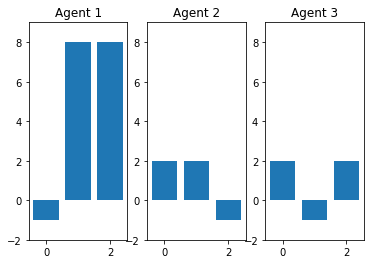

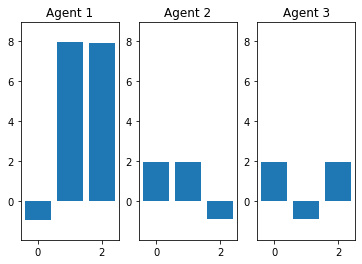

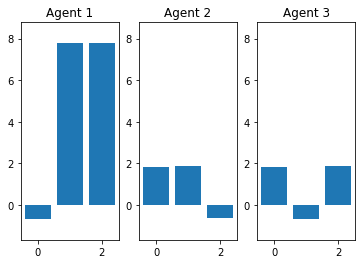

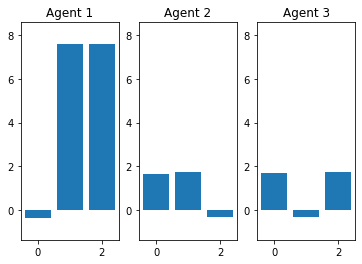

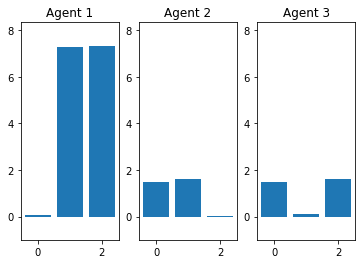

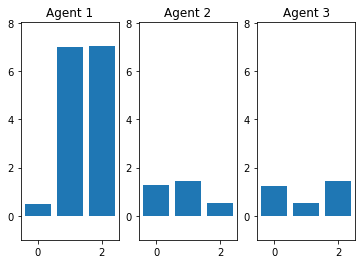

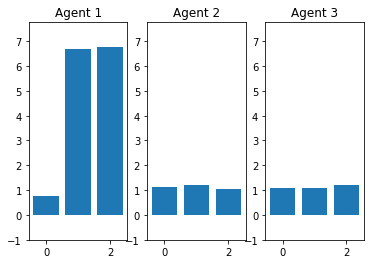

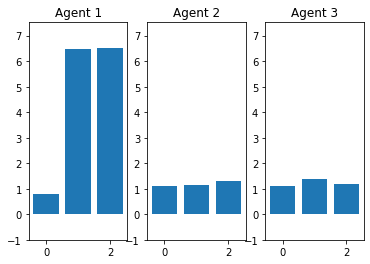

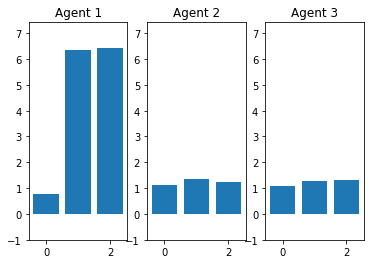

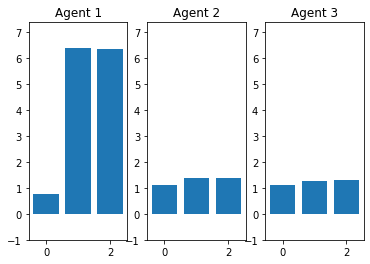

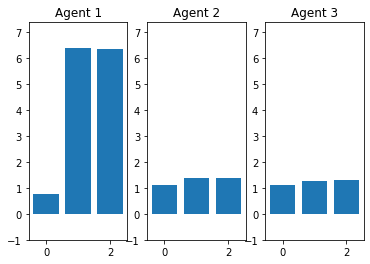

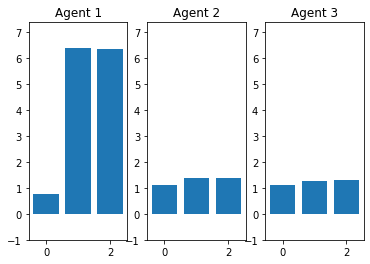

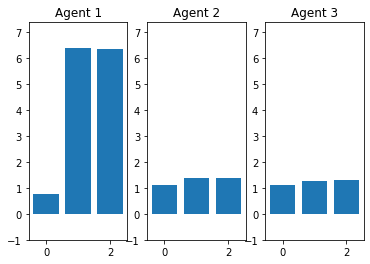

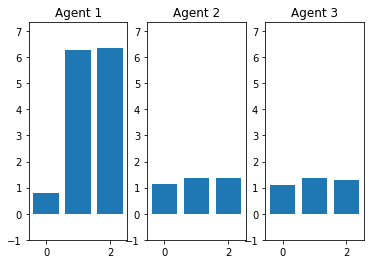

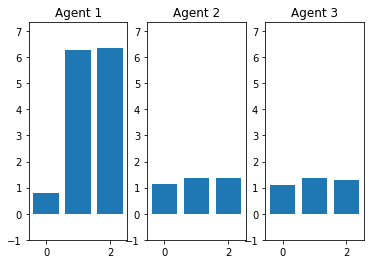

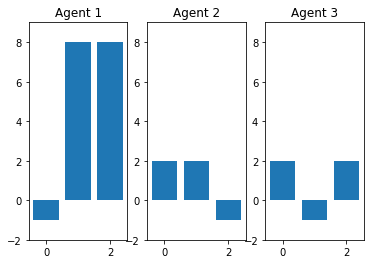

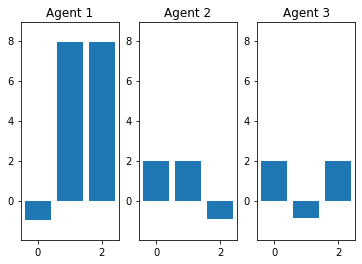

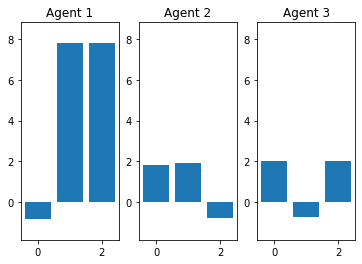

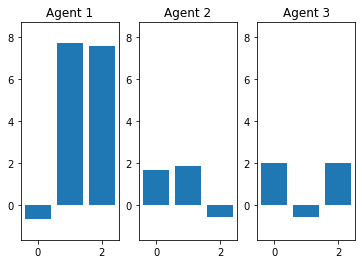

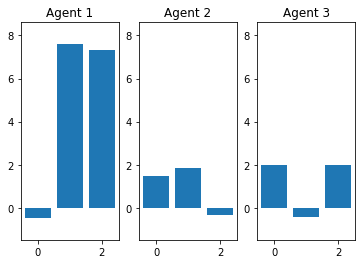

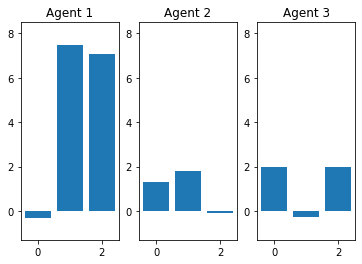

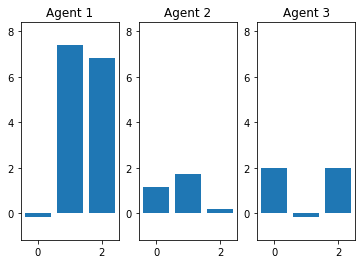

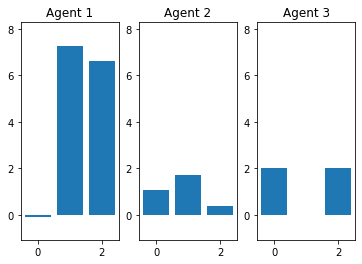

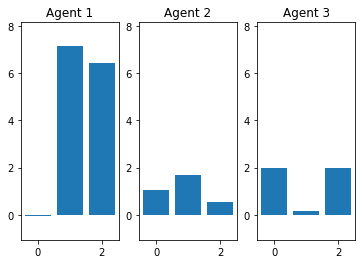

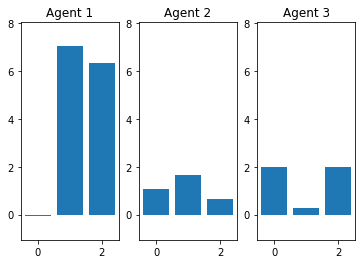

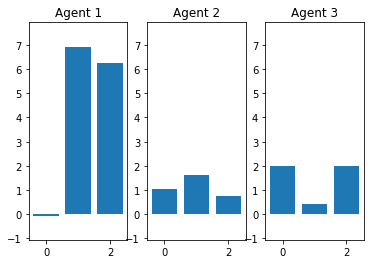

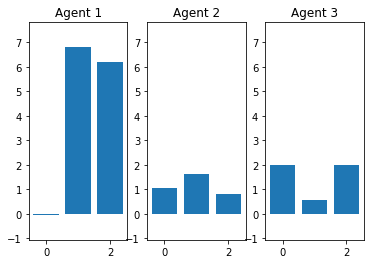

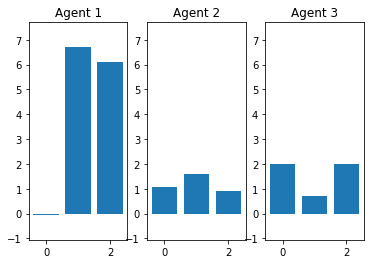

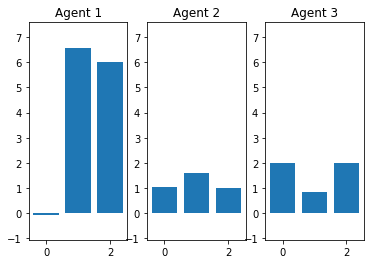

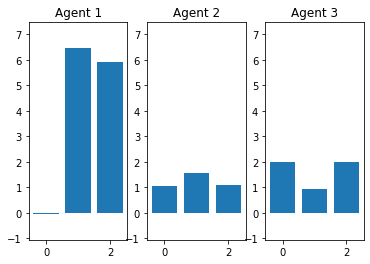

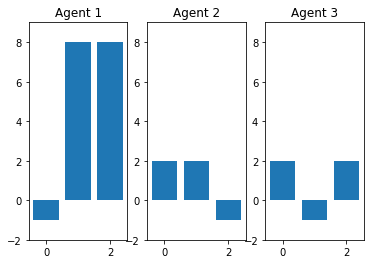

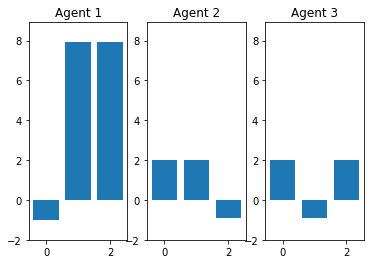

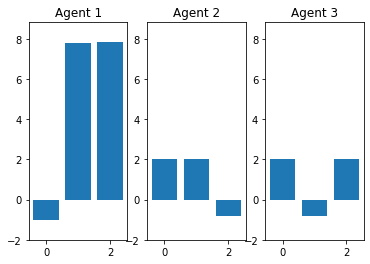

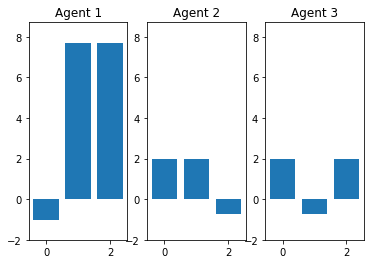

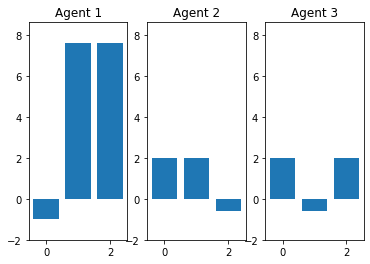

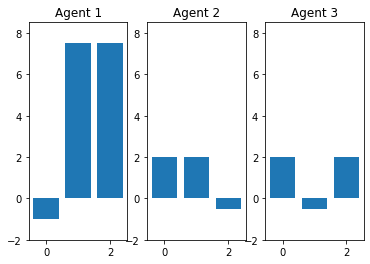

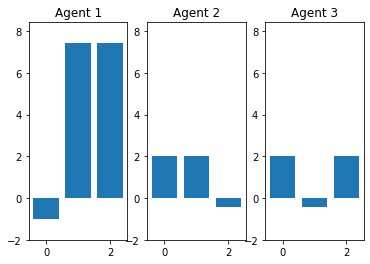

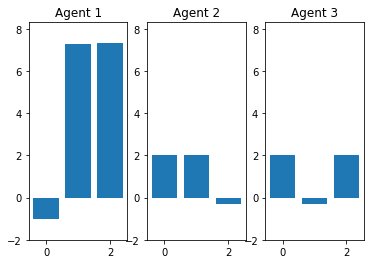

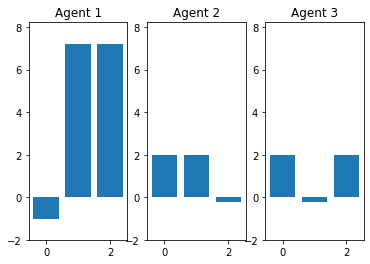

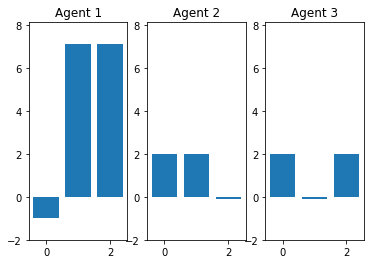

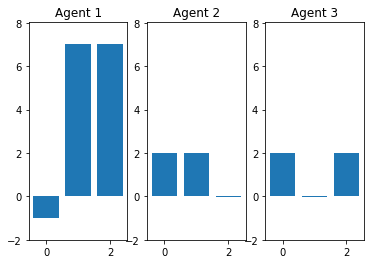

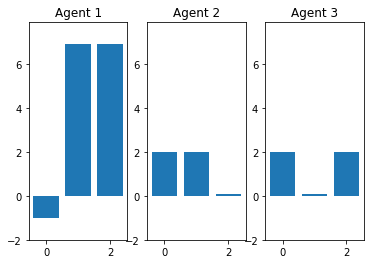

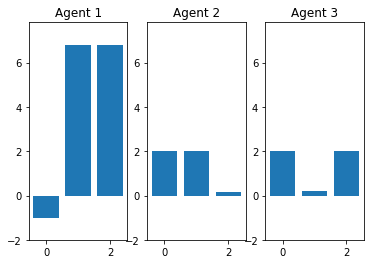

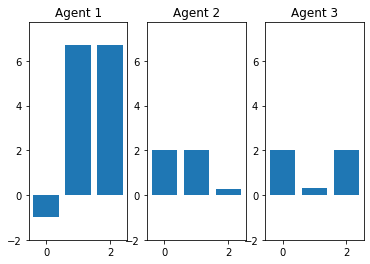

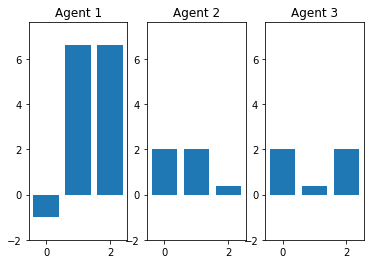

In [36]:
results = do_experiments(state, experiments)

In [37]:
# display the initial state
state

array([[-1.,  8.,  8.],
       [ 2.,  2., -1.],
       [ 2., -1.,  2.]])

In [38]:
results

[{'config': {'alpha': 0.0, 'beta': 0.1, 'r': 0.05, 'pure_tft': False},
  'envs': {'env_A': <__main__.Environment at 0x7fac8b78dd30>,
   'env_B': <__main__.Environment at 0x7fac8b78d6d8>,
   'env_C': <__main__.Environment at 0x7fac8b78d0b8>},
  'efficiency': 0.95,
  'speed': 0.59,
  'ut_c_cooperate': 3.54,
  'ut_c_defect': 3.86,
  'ut_a_cooperate_with_b_c_defect': 4.31,
  'ut_a_cooperate_with_b_c_cooperate': 5.26,
  'incentive-compatibility': -0.09,
  'safety': -0.95}]

In [39]:
results[0]['envs']['env_A'].state

array([[0.78106373, 6.28072484, 6.33279651],
       [1.1199011 , 1.3644574 , 1.36277365],
       [1.09903517, 1.35481776, 1.30442984]])

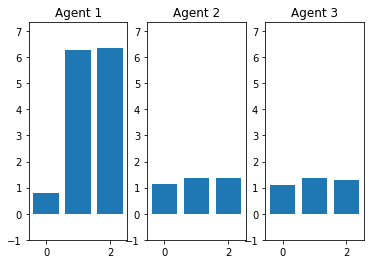

In [40]:
results[0]['envs']['env_A'].show()

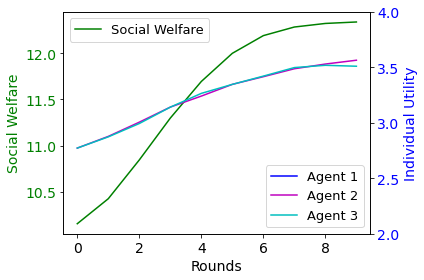

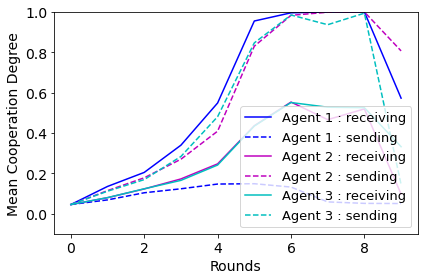

In [41]:
affiche(results[0]['envs']['env_A'],'0-defector', 2, 4, -0.1, 1)

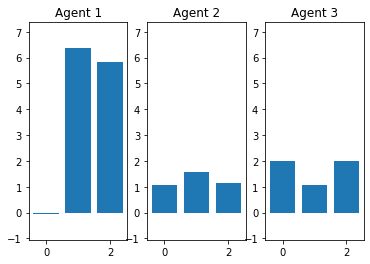

In [42]:
results[0]['envs']['env_B'].show()

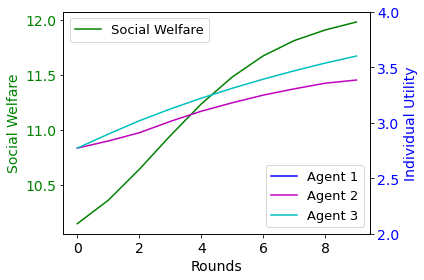

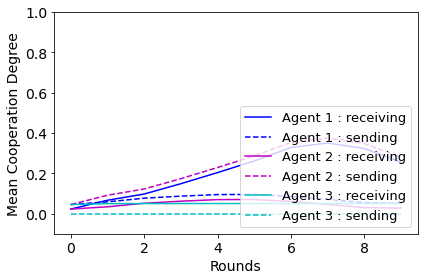

In [43]:
affiche(results[0]['envs']['env_B'],'1-defector', 2, 4, -0.1, 1)

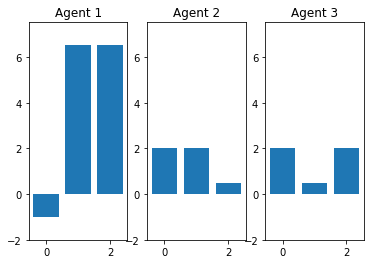

In [44]:
results[0]['envs']['env_C'].show()

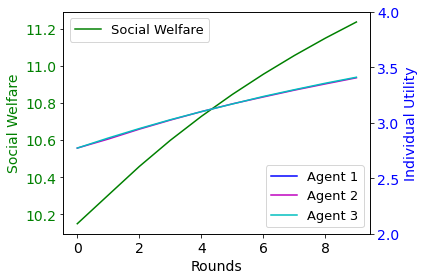

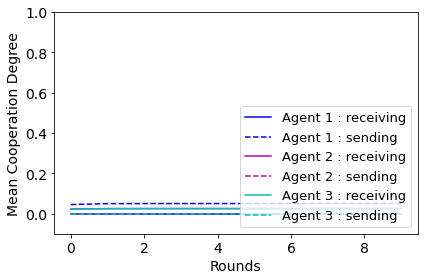

In [45]:
affiche(results[0]['envs']['env_C'],'2-defectors', 2, 4, -0.1, 1)

2020-11-13 17:05:31 - INFO -              analyse() - Env A, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:36 - INFO -              analyse() - Env A, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:39 - INFO -              analyse() - Env A, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:43 - INFO -              analyse() - Env A, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:48 - INFO -              analyse() - Env A, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:51 - INFO -              analyse() - Env A, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:05:56 - INFO -              analyse() - Env A, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:01 - INFO -              analyse() - Env A, episode:7


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:05 - INFO -              analyse() - Env A, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:09 - INFO -              analyse() - Env A, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:13 - INFO -              analyse() - Env A, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:18 - INFO -              analyse() - Env A, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:20 - INFO -              analyse() - Env A, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:25 - INFO -              analyse() - Env A, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:28 - INFO -              analyse() - Env A, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:32 - INFO -              analyse() - Env B, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:35 - INFO -              analyse() - Env B, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:39 - INFO -              analyse() - Env B, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:43 - INFO -              analyse() - Env B, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:46 - INFO -              analyse() - Env B, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:49 - INFO -              analyse() - Env B, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


/home/xavier/sharing_resources/sharing_resources/lib/python3.6/site-packages/ipykernel_launcher.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:53 - INFO -              analyse() - Env B, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:06:58 - INFO -              analyse() - Env B, episode:7


Stopping search: maximum iterations reached --> 200
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:02 - INFO -              analyse() - Env B, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:05 - INFO -              analyse() - Env B, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:10 - INFO -              analyse() - Env B, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:14 - INFO -              analyse() - Env B, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:18 - INFO -              analyse() - Env B, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:22 - INFO -              analyse() - Env B, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:26 - INFO -              analyse() - Env B, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:30 - INFO -              analyse() - Env C, episode:0


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:33 - INFO -              analyse() - Env C, episode:1


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:37 - INFO -              analyse() - Env C, episode:2


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:42 - INFO -              analyse() - Env C, episode:3


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:47 - INFO -              analyse() - Env C, episode:4


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:51 - INFO -              analyse() - Env C, episode:5


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:55 - INFO -              analyse() - Env C, episode:6


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:07:59 - INFO -              analyse() - Env C, episode:7


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:02 - INFO -              analyse() - Env C, episode:8


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:06 - INFO -              analyse() - Env C, episode:9


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:11 - INFO -              analyse() - Env C, episode:10


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:14 - INFO -              analyse() - Env C, episode:11


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:17 - INFO -              analyse() - Env C, episode:12


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:21 - INFO -              analyse() - Env C, episode:13


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


2020-11-13 17:08:25 - INFO -              analyse() - Env C, episode:14


Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08


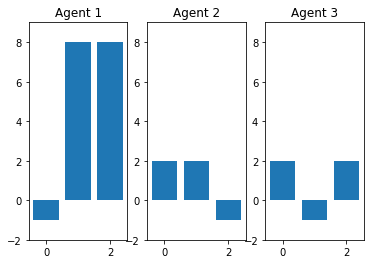

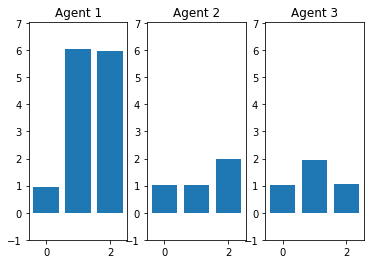

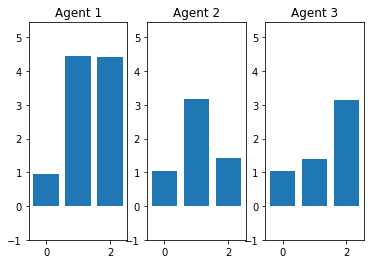

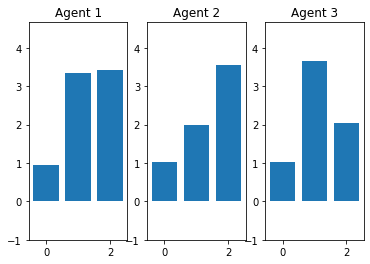

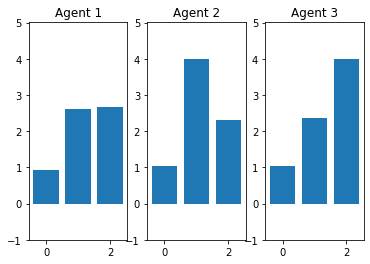

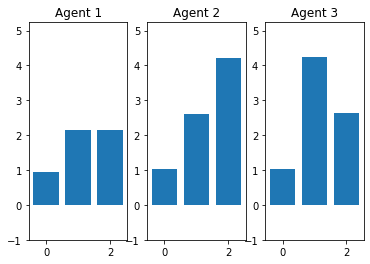

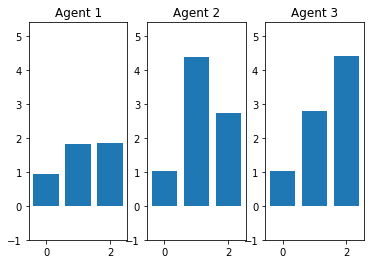

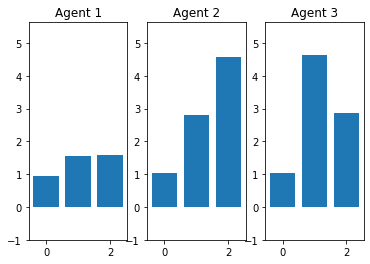

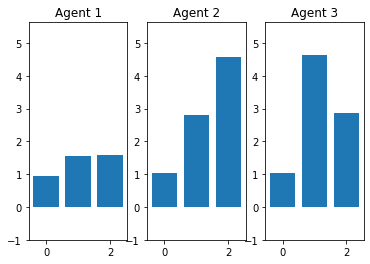

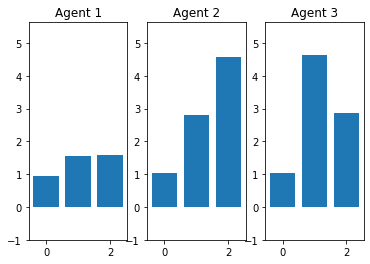

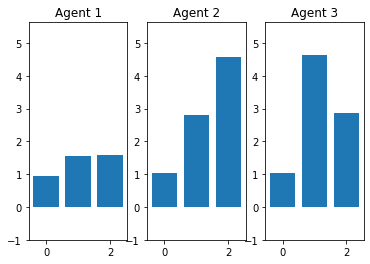

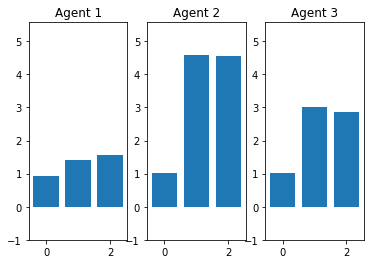

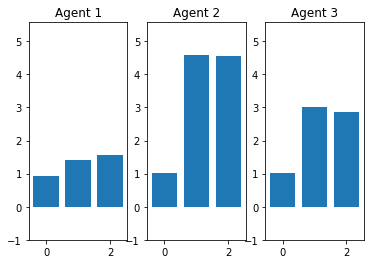

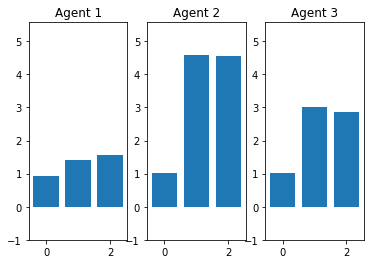

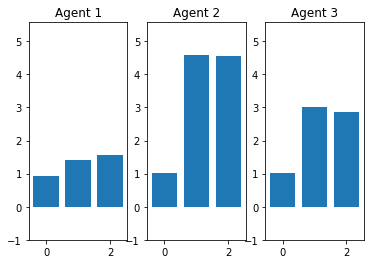

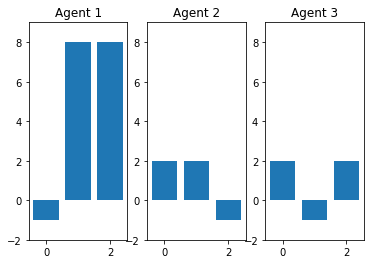

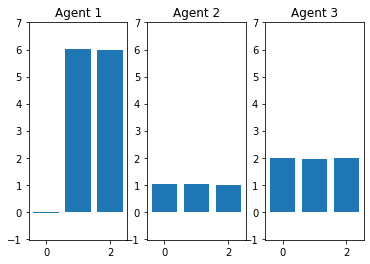

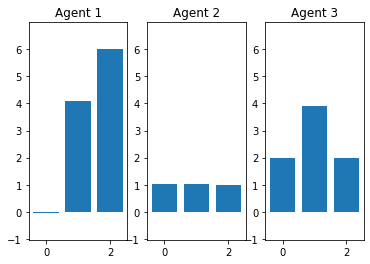

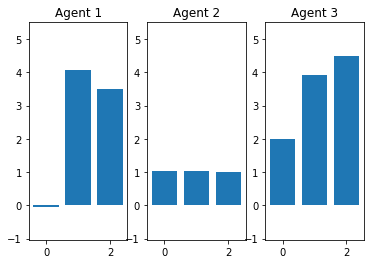

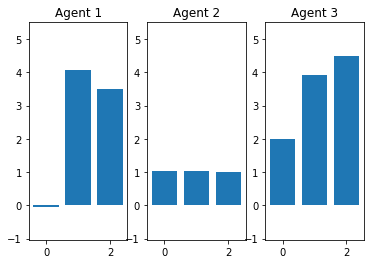

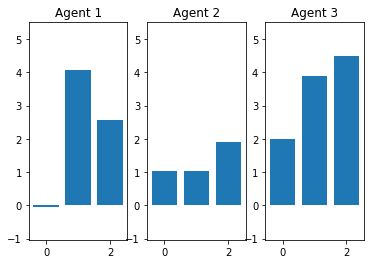

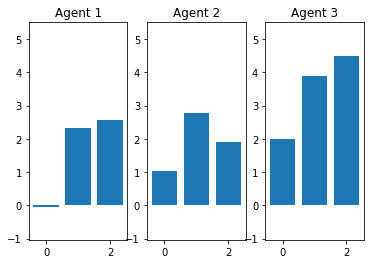

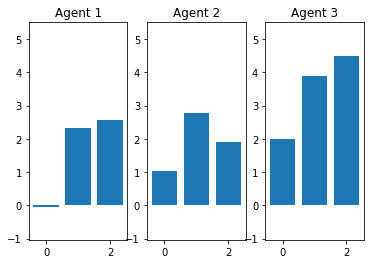

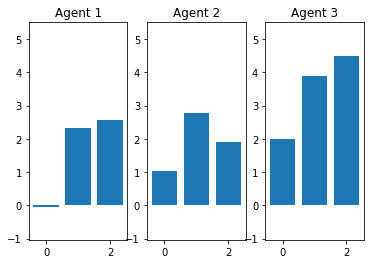

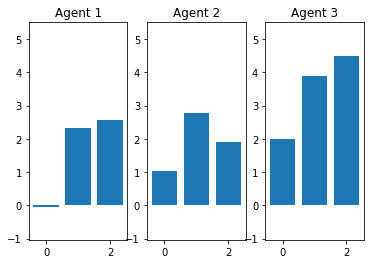

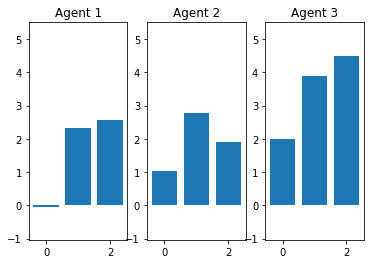

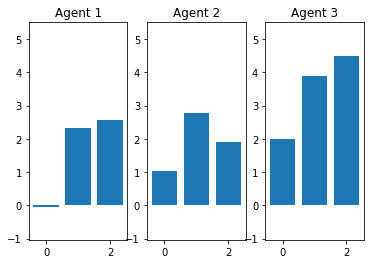

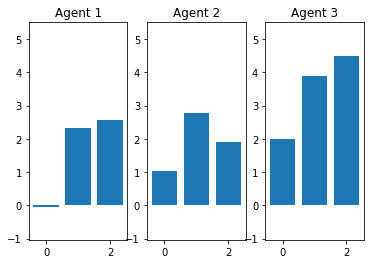

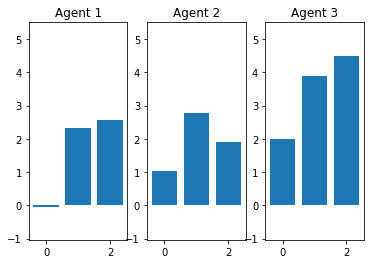

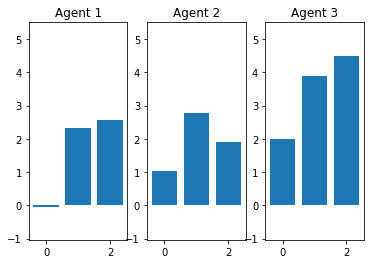

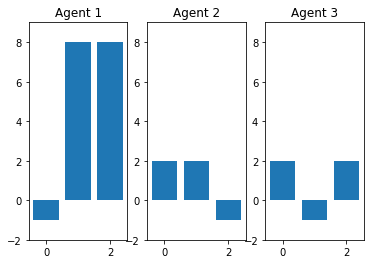

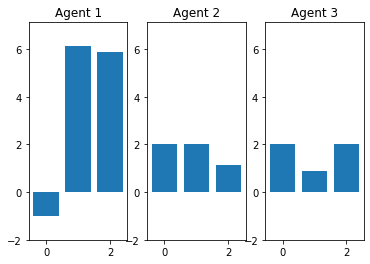

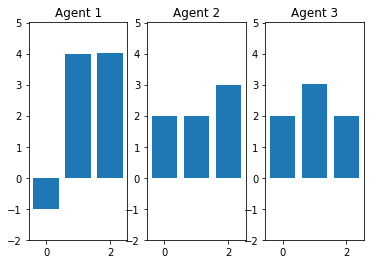

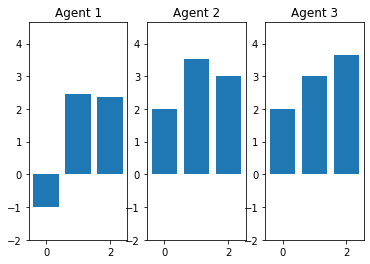

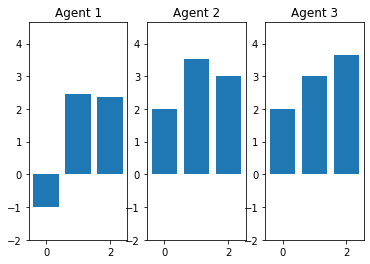

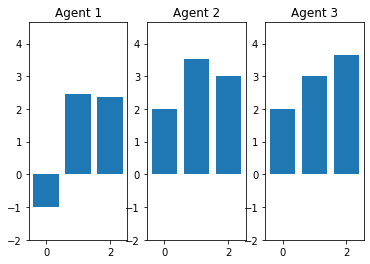

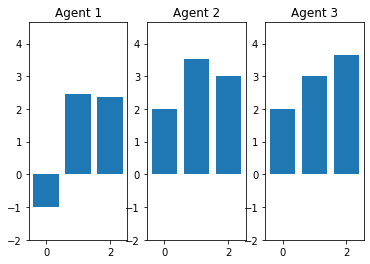

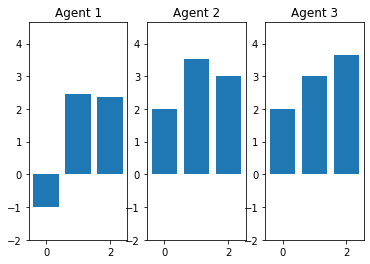

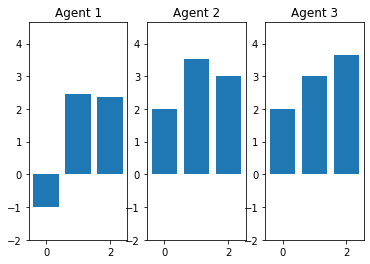

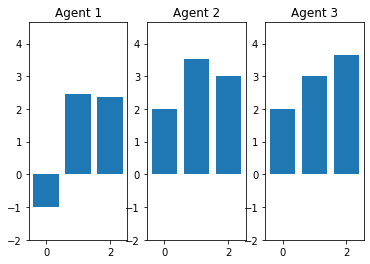

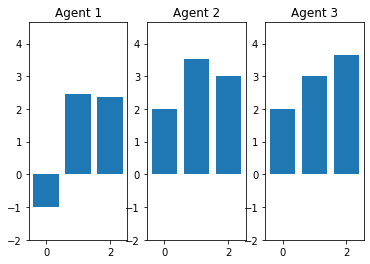

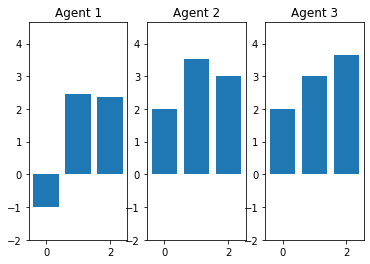

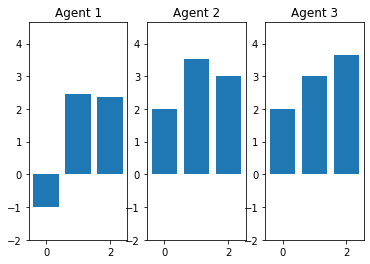

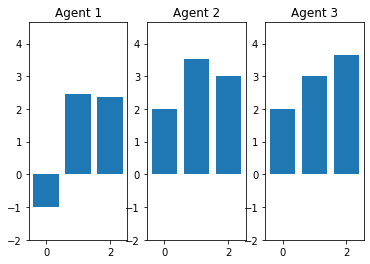

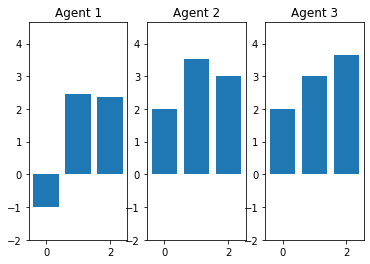

In [46]:
state = STATE_E
experiments_3 = [
    # beta, r, alpha
    (1.0, 0.0, 0.0),
]
results_ptft = do_experiments(STATE_F, experiments_3, pure_tft=True, n_iterations=15)

In [47]:
# display the initial state
state

array([[-1.,  2.,  2.],
       [ 2.,  2., -1.],
       [ 2., -1.,  2.]])

In [48]:
results_ptft

[{'config': {'alpha': 0.0, 'beta': 1.0, 'r': 0.0, 'pure_tft': True},
  'envs': {'env_A': <__main__.Environment at 0x7fac8bc083c8>,
   'env_B': <__main__.Environment at 0x7fac8bc08048>,
   'env_C': <__main__.Environment at 0x7fac8bc082e8>},
  'efficiency': 1,
  'speed': 0.85,
  'ut_c_cooperate': 4.3,
  'ut_c_defect': 5.04,
  'ut_a_cooperate_with_b_c_defect': 2.97,
  'ut_a_cooperate_with_b_c_cooperate': 3.58,
  'incentive-compatibility': -0.17,
  'safety': -0.61}]

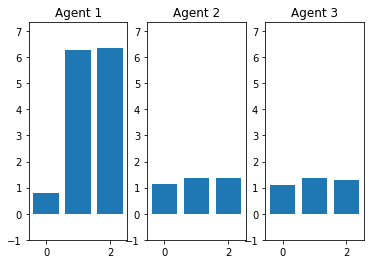

In [49]:
results[0]['envs']['env_A'].show()

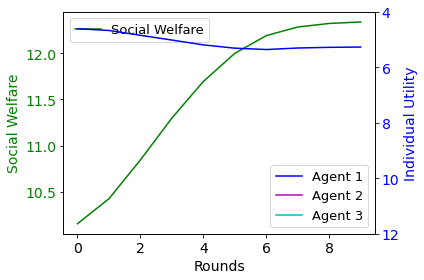

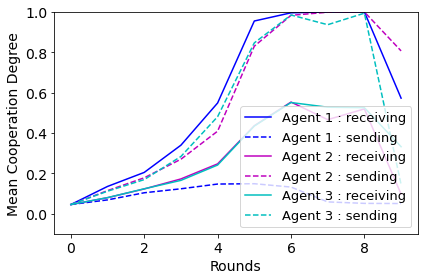

In [57]:
affiche(results[0]['envs']['env_A'],'0-defector', 12, 4, -0.1, 1)

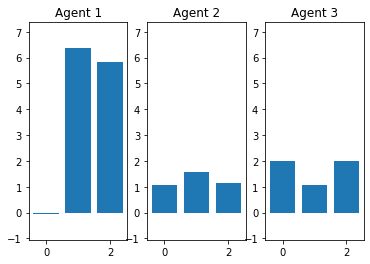

In [53]:
results[0]['envs']['env_B'].show()

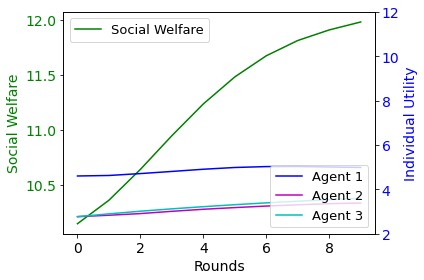

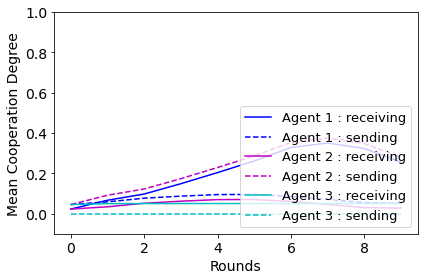

In [56]:
affiche(results[0]['envs']['env_B'],'1-defector', 2, 12, -0.1, 1)

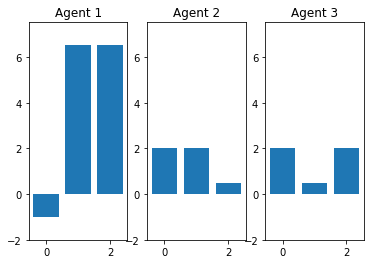

In [51]:
results[0]['envs']['env_C'].show()

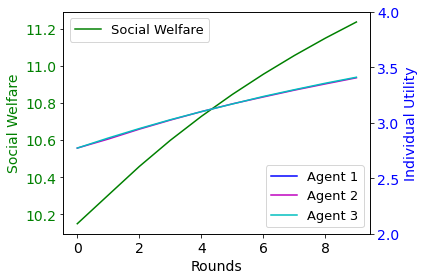

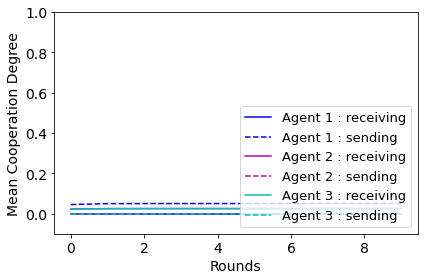

In [55]:
affiche(results[0]['envs']['env_C'],'2-defectors', 2, 4, -0.1, 1)